# K-means to find the best cluster numbers
The process is:
1. Importing the main libriaries
2. Importing the data frame with the RFM features
3. Test the K-means for different values of k
4. find the best value of k using the straight line that passes through the points (x=least number of cluster, y=highest value of wcss) and (x=highest number of cluster, y=value value of wcss) (Temporal J., Apr 13, 2019)
    * By finding the least distance of each point fro the Elbow Method Curve to the straight line we will have the best cluster value
    * The formual to use is :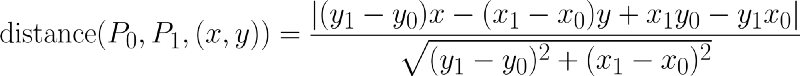
        * where:
            * P0 and P1 are the points with coordinates (x=least number of cluster, y=highest value of wcss) and (x=highest number of cluster, y=value value of wcss)
            * x and y are the cluster and its realtive wcss score
                * we will calculate the distance for each point of the Elbow Method Line
                
References:

Temporal J., Apr 13, (2019). *How to define the optimal number of clusters for KMeans* Retreived from https://jtemporal.com/kmeans-and-elbow-method/ on April 03, 2021

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns
import math as mt
from sklearn.preprocessing import MinMaxScaler

## Preparing the main DF

In [3]:
# defining the df
rfm_df = pd.read_csv('rfm_final.csv')
rfm_df.head()

,customer_unique_id,frequency,monetary_value,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,116
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,119
2,0000f46a3911fa3c0805444483337064,1,86.22,542
3,0000f6ccb0745a6a4b88665a16c9f078,1,43.62,326
4,0004aac84e0df4da2b147fca70cf8255,1,196.89,293


In [4]:
# add a column with unique integer ids:
rfm_df.insert(loc=1, column='id', value = [i for i in range(1 , len(rfm_df)+1)])

In [5]:
rfm_df

,customer_unique_id,id,frequency,monetary_value,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,1,1,141.90,116
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2,1,27.19,119
2,0000f46a3911fa3c0805444483337064,3,1,86.22,542
3,0000f6ccb0745a6a4b88665a16c9f078,4,1,43.62,326
4,0004aac84e0df4da2b147fca70cf8255,5,1,196.89,293
...,...,...,...,...,...
94393,fffcf5a5ff07b0908bd4e2dbc735a684,94394,1,2067.42,452
94394,fffea47cd6d3cc0a88bd621562a9d061,94395,1,84.58,267
94395,ffff371b4d645b6ecea244b27531430a,94396,1,112.46,573
94396,ffff5962728ec6157033ef9805bacc48,94397,1,133.69,124


In [6]:
# removing the 0 in the recency column
rfm_df.recency.replace({0:1}, inplace=True)

In [7]:
# checking the smalelst value in recency so to validate the replacement done above
rfm_df.recency.nsmallest(n=1)

94066    1
Name: recency, dtype: int64

the smallest value is 1, so the 0 has been replaced

In [71]:
# Let's Scale each feature of the rfm_df using the MinMAScaler, so to have each feature within a range of 0 and 1:
def min_max_scaling (dataframe, column_name):
    
    '''
    This function apply the MinMAxScale to a column of a dataframe and transform it
    it returns teh original_df with the orginal colmn and the scaled one
    
    ------------
    Parameters
    ------------
    
    dataframe: the dataframe where teh column we want to scale is in
    column_name: the feature to be scaled
    
    
    '''
    scaler = MinMaxScaler()
    dataframe[f'{column_name}_scaled'] = scaler.fit_transform(dataframe[[column_name]] )
    
    return dataframe

In [99]:
# Now let's generate the data frames for frequency, recency and monetary:
rfm_frq = rfm_df.drop(columns=['customer_unique_id', 'monetary_value', 'recency'])
rfm_rec = rfm_df.drop(columns=['customer_unique_id', 'monetary_value', 'frequency'])
rfm_mon = rfm_df.drop(columns=['customer_unique_id', 'recency', 'frequency'])

In [100]:
# Scaling each df using MinMaxScaler (in this way we reduce teh feature to a range from 0 to 1):
min_max_scaling(rfm_frq, 'frequency')
min_max_scaling(rfm_rec, 'recency')
min_max_scaling(rfm_mon, 'monetary_value')

,id,monetary_value,monetary_value_scaled
0,1,141.90,0.009690
1,2,27.19,0.001289
2,3,86.22,0.005612
3,4,43.62,0.002492
4,5,196.89,0.013717
...,...,...,...
94393,94394,2067.42,0.150707
94394,94395,84.58,0.005492
94395,94396,112.46,0.007534
94396,94397,133.69,0.009089


In [101]:
# Lets creating the scled df for to be used wit hte model:
rfm_frq_scaled = rfm_frq.drop(columns='frequency')
rfm_mon_scaled = rfm_mon.drop(columns='monetary_value')
rfm_rec_scaled = rfm_rec.drop(columns='recency')

In [103]:
rfm_rec_scaled.head()

,id,recency_scaled
0,1,0.157967
1,2,0.162088
2,3,0.743132
3,4,0.446429
4,5,0.401099


## Experimenting with teh K-means model:
* Creating a function tha returns the optimal cluster value
* Fitting teh model

In [105]:
# The below function will return the best k cluster for a given data frame:

def best_cluster_k(dataframe, num_of_cluster, plot=True):
    '''
    Used to find the best k value (aka teh best clustr value)
    
    This function calculates the within cluster sum of square for a range of k, using teh KMeans model.
    It then returns the best k cluster, by taking the cluster on the Elbow Method Curve that is 
    the most distant from the straight line that passes through the points x=least number of cluster, y=highest value of wcss
    where wcss stands fr within cluster sum of square
    
    ----------
    Parameters:
    ----------
    
    dataframe: DF data type - a data frame type, from whcih we need to predict the clusters
    
    num_of_cluster: Integer data type - maximum value of k, for the KMeans model, the model will be fit from 2 to num_of_cluster 
    
    plot: Boolean dtat type - True or False, default True, returns the plot of the Elbow Method Line
    
    ----------
    '''
    
# 1. We calcuate the wcss for each k cluster:

    wcss = [] # here we will store each wcss for each k
    K = range(2, (int((num_of_cluster) + 1))) # we will test teh model with 2 to "num_of_cluster" clusters 
    wcss_K_dic={}
    cluster_and_distance_dict = {}
    best_cluster_k_wcss= []

    for i in K:
        kmeans = KMeans(n_clusters=i, random_state=0)
        kmeans.fit(dataframe)
        wcss.append(kmeans.inertia_)
        wcss_K_dic[i] = kmeans.inertia_
    
# 2. We calculate the distance for each point on the Elbow Method curve (x=k cluster, y=wcss) from the straight line
    # that passes through points (x=least number of cluster, y=highest value of wcss) 
    # and (x=highest number of cluster, y=value value of wcss)
    # then we store the result in a dictionary with the k cluster and its distance

    x0 = num_of_cluster
    y0 = pd.Series(wcss, dtype='float64').min()
    x1 = 2
    y1 = pd.Series(wcss, dtype='float64').max()
  

    for x,y in wcss_K_dic.items():
        # calculate the distance of each poitn of the curve from the staright line:
        numerator = abs(((y1 - y0)*x) - ((x1 - x0)*y) + x1*y0 - y1*x0)
        denominator = mt.sqrt((y1 - y0)**2 + (x1 - x0)**2 )
        
        # inserting the distance into a dictionary so to have each cluster k with its distance from the linbe
        cluster_and_distance_dict[x] = (numerator/denominator)
        
        # inserting teh relative wcss value into a empty list which will be used as a columns so to return the wcss info as well alongside the k and distance
        best_cluster_k_wcss = wcss_K_dic.values()
    
# 3. we convert the cluster_and_distance_dict into a data frame and return tthe maximum value
    # in this way we will have the cluster which is the most distant from the straight line
    
    best_cluster_k = pd.DataFrame(list(cluster_and_distance_dict.items()), columns=['K-cluster', 'Distance_from_line'], 
                                  index=range(0, int((num_of_cluster - 1)))) # the minus 1 is to get the shape of the dataframe right, since the index starts from 0 to n-1

# 4. we create a new column into the df that will be returned, so to have teh wcss info as well

    best_cluster_k['wcss'] = best_cluster_k_wcss
    
    
# 4. adding also the graph of teh Elbow MEthod line
   
    if plot == True:
        plt.figure(figsize=(5, 5))
        plt.plot(K, wcss, 'bo-') # note the argument bo- means[color][marker][line style], which in this casae is blue, with marker as dot and line style as full and not dotted
        plt.xlabel('k')
        plt.ylabel('within cluster sums of squares')
        plt.title(f'The Elbow Method')
    
    return best_cluster_k.nlargest(n=1, columns='Distance_from_line')


In [113]:
# I have defined a function to try different k values and return a df that compare each best k value with its wcss:

def k_cluster_comparison(dataframe):
    
    '''
    Thsi function fit the df int a KMeans model and compare different wcss and distance from the line of 6 different ranges of k:
        from 2 to 5
        from 2 to 10
        from 2 to 20
        from 2 to 30
        from 2 to 40
        from 2 to 50
    and will return a data frame with all teh results
    
    ----------
    Parameters
    ----------
    
    dataframe: DF data type - the data fame that needs to be fitted into the KMeans model 
    
    '''
    
    dataframe_k5 = best_cluster_k(dataframe, 5, False)
    dataframe_k10 = best_cluster_k(dataframe, 10, False)
    
    return dataframe_k5.append([dataframe_k5, dataframe_k10])

#### Now we test different k values and see for each df the best cluster and its relative wcss score.

In [114]:
# Testing the Frequency
k_cluster_comparison(rfm_frq_scaled)

,K-cluster,Distance_from_line,wcss
1,3,0.984218,7.788746e+12
1,3,0.984218,7.788746e+12
2,4,4.249419,4.383988e+12


In [121]:
# Testing the Recency
k_cluster_comparison(rfm_rec_scaled)

,K-cluster,Distance_from_line,wcss
1,3,0.984219,7.788746e+12
1,3,0.984219,7.788746e+12
2,4,4.249419,4.383988e+12


In [122]:
# Testing the Monetary Value:
k_cluster_comparison(rfm_mon_scaled)

,K-cluster,Distance_from_line,wcss
1,3,0.984219,7.788746e+12
1,3,0.984219,7.788746e+12
2,4,4.249421,4.383983e+12


#### Some conclusions on cluster numbers:
* it is  worth considerign the feasibiility of differentiate the marketing campaigns and actions, according to each group, the more teh clusters the higher teh differentiation
* I believe that 3 clusters should suffice, since I believe that the maximum numberof clusters should be 5 (although I would chec wih a SME), and when chosing 5 clusters and comparing with the straight line, the best option is to use k=3, hence clustering the customers into 3 clusters

,K-cluster,Distance_from_line,wcss
1,3,0.984201,7.793573e+12


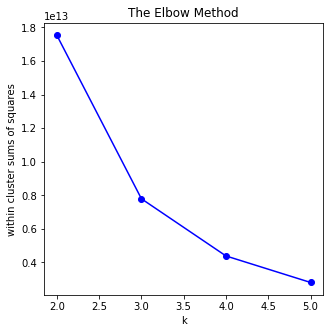

In [123]:
# the Elbow Model Curve for k=5:
best_cluster_k(rfm_mon, 5, True)

### Fitting the K-means model and generating  n clusters (k = n)

In [124]:
# Let's create a function taht fit the model and generates the data frame with the addition of with the cluster column

def creating_clusters(dataframe, n, name_of_the_cluster_column):
    
    '''
    This function will use kMeans algorithm with k = n to fit the data of the dta frame
    It returns teh daaframe with the clusters created
    
    
    -----------
    Parameters
    -----------
    
    dataframe: DF data type - the df that needs to be clustered
    
    n: Integer data type - the value of k (or how many clusters are needed)
    
    name_of_the_cluster_column: String datatype -  the name we want to givwe of the cluster columns
    
    '''
    # this will fit the model, creating teh cluster and return the full df with the cluster columns
    kmeans = KMeans(n_clusters=int(n), random_state=0)
    kmeans.fit(dataframe)
    cluster_columns = kmeans.predict(dataframe) + 1
    dataframe_clustered = dataframe.copy()
    dataframe_clustered[name_of_the_cluster_column] = cluster_columns
    

    return dataframe_clustered

In [125]:
# let's define a function that retunrs the descriptive statistics for the clustered df

def dexc_stat_clust_df(dataframe_clustered, name_of_the_column):
    '''
    This function returns descriptive statistics for the clustered dataframe
    grouped by the cluster columns.
    Such statistics allow to check the consistency of teh clusters vs the values that they contains
    
    -----------
    Parameters
    -----------
    
    dataframe_clustered: DF data type - teh dat frame that has been clustered
    
    
    name_of_the_column: String data type - the name of the column that contains the clusters
    
    '''
    
    dataframe_clustered_grouped = dataframe_clustered.groupby(by=name_of_the_column) # we use a groupby to gorup by clusters
    mask = dataframe_clustered_grouped.describe().columns.get_level_values(1).isin(['mean', 'std', 'count', 'max', 'min']) # this is to filter the df and return only the statistics we need
    
    return dataframe_clustered_grouped.describe().loc[:, mask].drop(columns='id') # we drop teh column id since is it of no use

In [128]:
# let's fit each data frame:
rfm_mon_clustered_k3 = creating_clusters(rfm_mon_scaled, 3, 'M_clusters')
rfm_frq_clustered_k3 = creating_clusters(rfm_frq_scaled, 3, 'F_clusters')
rfm_rec_clustered_k3 = creating_clusters(rfm_rec_scaled, 3, 'R_clusters')

## Sorting the cluster so that the lowest value will be within the lowest cluster
Thsi is done since the clustering works with the best fit, but does not take into account the order
By fizxing this issue we will be able to use the K-means to fidn the clusters, while also assigning the corrct values to each cluster
(by not doing so, the results will be incorrect since we will end up having high values in low cluster)

In [129]:
# Let's create a function that return a final data frame sorted

def cluster_order_fix(dataframe, variable_column_name, cluster_column_name, ascending):
    '''
    This function will split teh clustered df, sort the clusters in ascending order, sort the main df in
    ascending order by teh main variable (recency, frequency, or monetary), and return a final df with clusters
    associated according to the lowest to teh highest value to teh lowest to the highest clster

    ----------
    Parameters
    ----------
    dataframe: Df data type -  teh orignial data frame which includes teh variabe and the cluster columns
    
    variable_column_name: String data type - the colmn name of the main variable of teh df (recency, frequency, or monetary)
    
    cluster_column_name: String data type - the name of the columns of the cluster
    
    ascending: boolean - default True. Allwo t osort teh main df in ascending (True) or descending (False) order
    
    '''
#1. create a df with the clusters only and sort the value by the cluster
    df_cluster = pd.DataFrame(dataframe[cluster_column_name]).sort_values(by=cluster_column_name, ignore_index=True)
    df_cluster

#2. sort the rfm dataframe value by the main variable (recency, frequency, monetary) in ascending or descending order
    df_main = dataframe.sort_values(by=variable_column_name, ascending=ascending, ignore_index=True)
    df_main

#3. Merge the rfm dataframe with the cluster dataframe using the indexes:
    df_fixed = df_main.merge(df_cluster[cluster_column_name], how='inner', left_index=True, right_index=True)
    df_fixed

#4. Drop the extar column
    df_fixed.drop(columns=[f'{cluster_column_name}_x'], inplace=True)

#5. Rename teh cluster columns
    df_fixed.rename(columns={f'{cluster_column_name}_y': f'{cluster_column_name}'}, inplace=True)
    
    return df_fixed

## Monetary_value df

In [137]:
# lets' start to fix the Monetary_value df:
rfm_mon_clustered_k3.groupby(by='M_clusters').describe()

id                                                    \
              count     mean          std      min       25%      50%   
M_clusters                                                              
1           31496.0  47177.5  9092.256376  31430.0  39303.75  47177.5   
2           31429.0  15715.0  9072.915142      1.0   7858.00  15715.0   
3           31473.0  78662.0  9085.616848  62926.0  70794.00  78662.0   

                              monetary_value_scaled                      \
                 75%      max                 count      mean       std   
M_clusters                                                                
1           55051.25  62925.0               31496.0  0.011377  0.016036   
2           23572.00  31429.0               31429.0  0.011425  0.016869   
3           86530.00  94398.0               31473.0  0.011399  0.016768   

                                                              
                 min       25%       50%       75%       max  
M_clusters                                                    
1           0.000149  0.003908  0.007196  0.012694  0.532081  
2           0.000000  0.003937  0.007223  0.012648  1.000000  
3           0.000035  0.003898  0.007156  0.012671  0.553813

**as we can see if we do not fix the sorting we will have clusters with value that do not make much sense (i.e. the highest spent should be in the highest cluster, which with 3 cluster is the 3rd)**

In [139]:
# Let's apply the fixing function:
rfm_mon_clustered_k3_sorted = cluster_order_fix(rfm_mon_clustered_k3,'monetary_value_scaled' , 'M_clusters', True)
rfm_mon_clustered_k3_sorted

,id,monetary_value_scaled,M_clusters
0,18312,0.000000,1
1,69794,0.000035,1
2,66192,0.000095,1
3,14968,0.000149,1
4,41173,0.000149,1
...,...,...,...
94393,25728,0.506253,3
94394,81351,0.506772,3
94395,43674,0.532081,3
94396,80517,0.553813,3


In [141]:
# lets check teh descriptive statistics using teh function I have created:
dexc_stat_clust_df(rfm_mon_clustered_k3_sorted, 'M_clusters')

monetary_value_scaled                                        
                           count      mean       std       min       max
M_clusters                                                              
1                        31496.0  0.002956  0.001097  0.000000  0.004806
2                        31429.0  0.007332  0.001598  0.004807  0.010414
3                        31473.0  0.023913  0.023968  0.010414  1.000000

**as we can see now we have the maximu value at the highest cluster (meaning that the highest spending custoemrs are now in the highest cluster)**

## Recency df

In [147]:
# let's fix the recency df:
# Note: The order for recency is descending, meeaning that the highest the value the lowest the cluster associated
rfm_rec_clustered_k3_sorted = cluster_order_fix(rfm_rec_clustered_k3, 'recency_scaled', 'R_clusters', False)
rfm_rec_clustered_k3_sorted.head()

,id,recency_scaled,R_clusters
0,67873,1.000000,1
1,51991,0.960165,1
2,42733,0.960165,1
3,36237,0.960165,1
4,17559,0.960165,1


In [148]:
# let's check the descriptive statistics:
dexc_stat_clust_df(rfm_rec_clustered_k3_sorted, 'R_clusters')

recency_scaled                                        
                    count      mean       std       min       max
R_clusters                                                       
1                 31496.0  0.579426  0.116956  0.402473  1.000000
2                 31429.0  0.307300  0.057485  0.208791  0.402473
3                 31473.0  0.109322  0.059497  0.000000  0.208791

**we can see that the lowest value is in the 3rd cluster (in this case a lower value indicates a recent purchase)**

## Frequency DF

In [150]:
# let's fix the frequency df
rfm_frq_clustered_k3_sorted = cluster_order_fix(rfm_frq_clustered_k3, 'frequency_scaled', 'F_clusters', True)
rfm_frq_clustered_k3_sorted

,id,frequency_scaled,F_clusters
0,1,0.000000,1
1,62472,0.000000,1
2,62471,0.000000,1
3,62470,0.000000,1
4,62469,0.000000,1
...,...,...,...
94393,74743,0.400000,3
94394,37140,0.400000,3
94395,10175,0.400000,3
94396,23042,0.533333,3


In [151]:
#let's check the descriptive statistics
dexc_stat_clust_df(rfm_frq_clustered_k3_sorted,'F_clusters')

frequency_scaled                              
                      count      mean       std  min  max
F_clusters                                               
1                   31496.0  0.000000  0.000000  0.0  0.0
2                   31429.0  0.000000  0.000000  0.0  0.0
3                   31473.0  0.006749  0.023676  0.0  1.0

## Creating one rfm df with the clusters:

In [161]:
# Let's join the main rfm table with teh others so to obtain a final data frame (the total rows must be 94398):
# Frequency

rfm_final_with_clusters = rfm_df.merge(rfm_frq_clustered_k3_sorted['F_clusters'], how='inner', left_on=rfm_df.id, 
                                       right_on=rfm_frq_clustered_k3_sorted.id)

In [162]:
# dropping teh exrta columns tha is returned:
rfm_final_with_clusters.drop(columns='key_0', inplace=True)

In [163]:
# Monetary
rfm_final_with_clusters = rfm_final_with_clusters.merge(rfm_mon_clustered_k3_sorted['M_clusters'], how='inner',
                                                       left_on=rfm_final_with_clusters.id, 
                                                        right_on=rfm_mon_clustered_k3_sorted.id)

In [164]:
# dropping teh exrta columns tha is returned:
rfm_final_with_clusters.drop(columns='key_0', inplace=True)

In [165]:
# Recency
rfm_final_with_clusters = rfm_final_with_clusters.merge(rfm_rec_clustered_k3_sorted['R_clusters'], how='inner',
                                                       left_on=rfm_final_with_clusters.id, 
                                                        right_on=rfm_rec_clustered_k3_sorted.id)

In [166]:
# dropping teh exrta columns tha is returned:
rfm_final_with_clusters.drop(columns='key_0', inplace=True)

In [167]:
rfm_final_with_clusters

,customer_unique_id,id,frequency,monetary_value,recency,F_clusters,M_clusters,R_clusters
0,0000366f3b9a7992bf8c76cfdf3221e2,1,1,141.90,116,1,2,3
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2,1,27.19,119,2,1,3
2,0000f46a3911fa3c0805444483337064,3,1,86.22,542,2,2,1
3,0000f6ccb0745a6a4b88665a16c9f078,4,1,43.62,326,2,1,1
4,0004aac84e0df4da2b147fca70cf8255,5,1,196.89,293,2,3,2
...,...,...,...,...,...,...,...,...
94393,fffcf5a5ff07b0908bd4e2dbc735a684,94394,1,2067.42,452,1,3,1
94394,fffea47cd6d3cc0a88bd621562a9d061,94395,1,84.58,267,1,2,2
94395,ffff371b4d645b6ecea244b27531430a,94396,1,112.46,573,1,2,1
94396,ffff5962728ec6157033ef9805bacc48,94397,1,133.69,124,1,2,3


The rows are the amount expected

In [168]:
# a check on the outlier
rfm_final_with_clusters.loc[rfm_final_with_clusters.frequency==16]

,customer_unique_id,id,frequency,monetary_value,recency,F_clusters,M_clusters,R_clusters
52022,8d50f5eadf50201ccdcedfb9e2ac8455,52023,16,902.04,14,3,3,3


In [171]:
# reorderign teh columns:
rfm_final_with_clusters = rfm_final_with_clusters[['customer_unique_id', 'id', 'recency', 'frequency', 'monetary_value', 'R_clusters', 'F_clusters', 'M_clusters']]
# with a double check that everything is ok
rfm_final_with_clusters.loc[rfm_final_with_clusters.frequency==16]                  

,customer_unique_id,id,recency,frequency,monetary_value,R_clusters,F_clusters,M_clusters
52022,8d50f5eadf50201ccdcedfb9e2ac8455,52023,14,16,902.04,3,3,3


In [189]:
# The final df:
rfm_final_with_clusters

,customer_unique_id,id,recency,frequency,monetary_value,R_clusters,F_clusters,M_clusters
0,0000366f3b9a7992bf8c76cfdf3221e2,1,116,1,141.90,3,1,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2,119,1,27.19,3,2,1
2,0000f46a3911fa3c0805444483337064,3,542,1,86.22,1,2,2
3,0000f6ccb0745a6a4b88665a16c9f078,4,326,1,43.62,1,2,1
4,0004aac84e0df4da2b147fca70cf8255,5,293,1,196.89,2,2,3
...,...,...,...,...,...,...,...,...
94393,fffcf5a5ff07b0908bd4e2dbc735a684,94394,452,1,2067.42,1,1,3
94394,fffea47cd6d3cc0a88bd621562a9d061,94395,267,1,84.58,2,1,2
94395,ffff371b4d645b6ecea244b27531430a,94396,573,1,112.46,1,1,2
94396,ffff5962728ec6157033ef9805bacc48,94397,124,1,133.69,3,1,2


### Note For me (yo ask Sara why is not working):

**Check the solution SAra gave me**


1. Try to figure out how to plt the line
2. compute the best cluster function for all data frame
3. create a new data frame with the clusters fro each feature of the RFM

I wrote thsi code but it did not work, the line did not pass through the pints, I guess is something wrong with the scale:

* x0 = 10
* y0 = pd.Series(wcss, dtype='float64').min()
* x1 = 2
* y1 = pd.Series(wcss, dtype='float64').max()
* m = (y1 - y0)/(x1 - x0)
* c = (y1 - y0)- m*(x1 - x0)
* y_eq = [] 

    for i in x_eq:
        line = m*i + c
        y_eq.append(line)
        
        